<div style='text-align: center;'>
<span style="color:#000000; font-family: 'Garamond'; font-weight: 700; font-size: 2em;"> Convolutional Artificial Neural Network to paint grayscale images </span>
</div>


------------------------------------------------------------------------------------------------------------------------------


<div style='text-align: center;'>
<span style="color:#000000; font-family: 'Times new roman'; font-weight: 700; font-size: 2em;"> 1. Import of requered modules and libreries </span>
</div>


In [1]:
# First we import all the required libraries or modules to the environment

import torchvision as tv
import torch
from torch.utils.data import DataLoader,TensorDataset,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as fn
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
import cv2
import os
import time

<div style='text-align: center;'>
<span style="color:#000000; font-family: 'Times new roman'; font-weight: 700; font-size: 2em;"> 2. Creation of a python class for resizing and transforming all the dog images </span>
</div>



In [2]:
class CustomDataset(Dataset):
    def __init__(self):
        carpetas=os.listdir('D:/descargas/datasets/Data')
        self.imagenes=[]
        for carpeta in carpetas:
            for imagen in os.listdir('D:/descargas/datasets/Data/'+carpeta):
                self.imagenes.append('D:/descargas/datasets/Data/'+carpeta+'/'+imagen)
        
    def __len__(self):
       
        return len(self.imagenes)
    def __getitem__(self,idx):
        
        entrada=cv2.cvtColor(cv2.resize(cv2.imread(self.imagenes[idx]),(256,256)),cv2.COLOR_BGR2GRAY)
        entrada=np.swapaxes(entrada.reshape(256,256,1),0,2)/255
        salida=cv2.resize(cv2.imread(self.imagenes[idx]),(256,256))
        salida=np.swapaxes(salida,0,2)/255
        return torch.Tensor(entrada),torch.Tensor(salida)
        

<div style='text-align: center;'>
<span style="color:#000000; font-family: 'Times new roman'; font-weight: 700; font-size: 2em;"> 3. Data analysis, creation of the dataset, and visualization  of some examples </span>
</div>


In [3]:
data=CustomDataset()

In [4]:
print("forma data de entrada: ",data[0][0].shape)
print("forma data de salida: ",data[0][1].shape)

forma data de entrada:  torch.Size([1, 256, 256])
forma data de salida:  torch.Size([3, 256, 256])


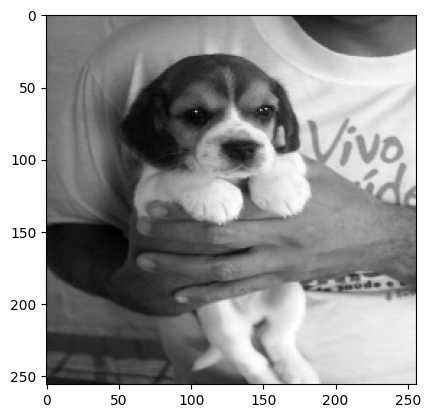

In [5]:
plt.imshow(np.swapaxes(data[0][0],0,2),'gray')

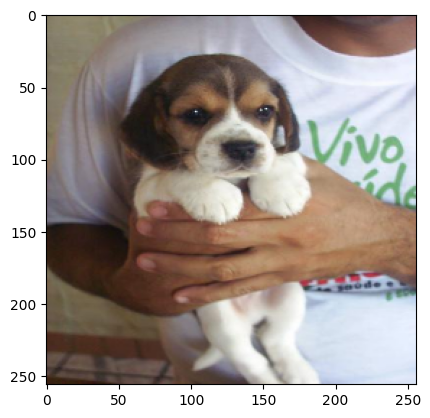

In [6]:
plt.imshow(cv2.cvtColor(np.swapaxes(data[0][1],0,2).numpy(),cv2.COLOR_BGR2RGB))

<div style='text-align: center;'>
<span style="color:#000000; font-family: 'Times new roman'; font-weight: 700; font-size: 2em;"> 4. Data split and creation of training and testing datasets </span>
</div>


In [7]:
train_data,test_data=torch.utils.data.random_split(data,[round(len(data)*0.8),round(len(data)*0.2)])

In [8]:
print("datos para train: ",len(train_data))
print("datos para test: ",len(test_data))

datos para train:  1316
datos para test:  329


<div style='text-align: center;'>
<span style="color:#000000; font-family: 'Times new roman'; font-weight: 700; font-size: 2em;"> 5. Dataloaders & Design of the Network </span>
</div>


In [9]:
trainLoader=DataLoader(train_data,batch_size=32,shuffle=True)
testLoader=DataLoader(test_data,batch_size=32)

In [10]:
class AutoEnc(nn.Module):
              
    def __init__(self):
        
        super().__init__()
        self.encoder=nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.ReLU()
          
            
     
              
        )
        self.decoder=nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(512,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(256,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(128,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(64,32,kernel_size=3,padding=1),
            nn.Tanh(),
            nn.ConvTranspose2d(32,3,kernel_size=3,padding=1),
            
                             
        )
        
          
    def forward(self,x):
      
        x=self.encoder(x)
        x=self.decoder(x)
      
        
        return x

<div style='text-align: center;'>
<span style="color:#000000; font-family: 'Times new roman'; font-weight: 700; font-size: 2em;"> 6. Neural Network architecture </span>
</div>


In [11]:
red=AutoEnc()
red.to('cuda')

AutoEnc(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [12]:
summary(red,input_size=(1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
              ReLU-2         [-1, 32, 256, 256]               0
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
              ReLU-5         [-1, 64, 128, 128]               0
         MaxPool2d-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
              ReLU-8          [-1, 128, 64, 64]               0
         MaxPool2d-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]         295,168
             ReLU-11          [-1, 256, 32, 32]               0
        MaxPool2d-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 512, 16, 16]       1,180,160
             ReLU-14          [-1, 512,

<div style='text-align: center;'>
<span style="color:#000000; font-family: 'Times new roman'; font-weight: 700; font-size: 2em;"> 7. Training process </span>
</div>


In [44]:
inicio=time.time()
red=AutoEnc()
red.to('cuda')
lossFunct=nn.MSELoss()
optimizador=torch.optim.Adam(red.parameters(),lr=1e-4)
aplanar=nn.Flatten(1)
epocas=200
TrainError=[]
TestError=[]

for iteraciones in range(epocas):
    error_test=0
    error_train=0
# DataX = imagen en gray scale, DataY= imagen original RGB 
# bloque de entrenamiento
    for DataX,DataY in trainLoader:
        DataX=DataX.to('cuda')
        DataY=DataY.to('cuda')
        #FORWARD propagation
        y_pred=red(DataX)
        y_pred=aplanar(y_pred)
        DataY = aplanar(DataY)
        J=lossFunct(y_pred,DataY)
        # Back propagation
        optimizador.zero_grad()
        J.backward()
        optimizador.step()
        error_train+=J.item()
# Bloque Test
# testLoader utiliza el set de datos de prueba
    with torch.no_grad():
        for DataX,DataY in testLoader:
                        
            DataX=DataX.to('cuda')
            DataY=DataY.to('cuda')
            #FORWARD propagation
            y_pred=red(DataX)
            y_pred=aplanar(y_pred)
            DataY = aplanar(DataY)
            J=lossFunct(y_pred,DataY)
            error_test+=J.item()
# Almacenar el error para los graficos          
    TrainError.append((error_train/len(train_data))*100)
    TestError.append((error_test/len(test_data))*100)
    # imprimir el error por epoca
    print(f'Epocas: {iteraciones}      costo: {TrainError[iteraciones]} %     costoTest: {TestError[iteraciones]} %')
fin=time.time()
tiempo=fin-inicio
print('GPU time: {:.2f}s'.format(tiempo))

Epocas: 0      costo: 0.32743331905465717 %     costoTest: 0.13763717967326156 %
Epocas: 1      costo: 0.09588667610518657 %     costoTest: 0.07675128131199029 %
Epocas: 2      costo: 0.06495563413857236 %     costoTest: 0.0626631143381168 %
Epocas: 3      costo: 0.05726562140617056 %     costoTest: 0.07426107647661742 %
Epocas: 4      costo: 0.05441035588461577 %     costoTest: 0.05501419458662848 %
Epocas: 5      costo: 0.0501563074067235 %     costoTest: 0.050591590239646586 %
Epocas: 6      costo: 0.04671060177285258 %     costoTest: 0.0488222004862723 %
Epocas: 7      costo: 0.04698024563049744 %     costoTest: 0.04955290768601249 %
Epocas: 8      costo: 0.04530316374426011 %     costoTest: 0.04741024356165555 %
Epocas: 9      costo: 0.04381266051739183 %     costoTest: 0.04492043305222387 %
Epocas: 10      costo: 0.04294719433802602 %     costoTest: 0.04406304305311757 %
Epocas: 11      costo: 0.04225376035202872 %     costoTest: 0.0446259981094885 %
Epocas: 12      costo: 0.0411

Epocas: 100      costo: 0.029510745564956888 %     costoTest: 0.03253148053418902 %
Epocas: 101      costo: 0.02962086019941286 %     costoTest: 0.038814927114451184 %
Epocas: 102      costo: 0.030569532018517198 %     costoTest: 0.033599061546082915 %
Epocas: 103      costo: 0.030616925545263254 %     costoTest: 0.03646483197581804 %
Epocas: 104      costo: 0.030417052503833746 %     costoTest: 0.03189167438080608 %
Epocas: 105      costo: 0.029428429210892566 %     costoTest: 0.03185610323691441 %
Epocas: 106      costo: 0.029087888988408635 %     costoTest: 0.03110797478503188 %
Epocas: 107      costo: 0.029193515405285322 %     costoTest: 0.03353238366204555 %
Epocas: 108      costo: 0.029642817155262707 %     costoTest: 0.030830301950178975 %
Epocas: 109      costo: 0.029308274692620824 %     costoTest: 0.030973935528095006 %
Epocas: 110      costo: 0.0294839039778954 %     costoTest: 0.03288814226182398 %
Epocas: 111      costo: 0.029456635334141168 %     costoTest: 0.03379293148

Epocas: 198      costo: 0.02439104411241494 %     costoTest: 0.031326092938159376 %
Epocas: 199      costo: 0.024411258766127576 %     costoTest: 0.032026010726813485 %
GPU time: 2963.62s


<div style='text-align: center;'>
<span style="color:#000000; font-family: 'Times new roman'; font-weight: 700; font-size: 2em;"> 8. Showing results and examples </span>
</div>


In [172]:
n=128
image=red(train_data[n][0].unsqueeze(0).to('cuda')).to('cpu').detach()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


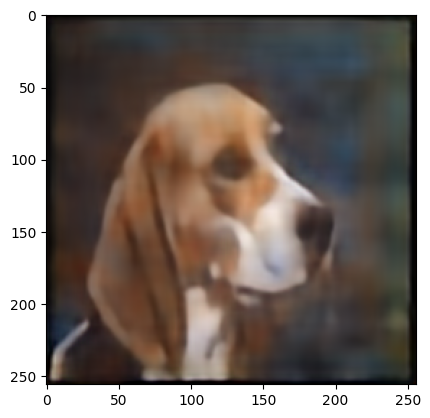

In [173]:
plt.imshow(cv2.cvtColor(np.swapaxes(image.squeeze(0),0,2).numpy(),cv2.COLOR_BGR2RGB))

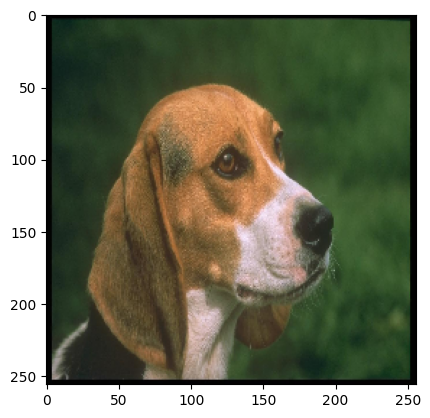

In [174]:
plt.imshow(cv2.cvtColor(np.swapaxes(train_data[n][1],0,2).numpy(),cv2.COLOR_BGR2RGB))

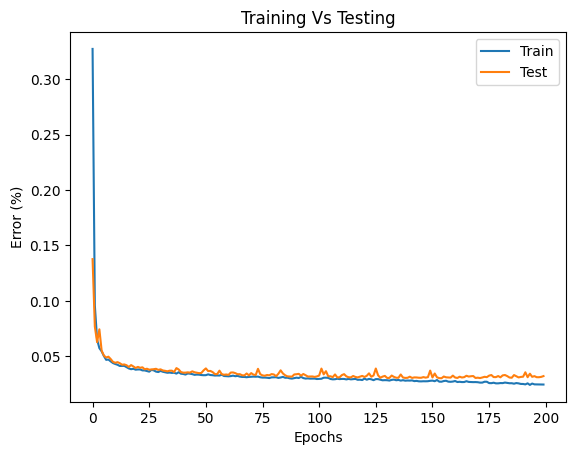

In [109]:
plt.plot(TrainError)
plt.plot(TestError)
plt.title('Training Vs Testing')
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.legend(['Train', 'Test '])

<div style='text-align: center;'>
<span style="color:#000000; font-family: 'Times new roman'; font-weight: 700; font-size: 2em;"> 9. Testing the model with other kind of images </span>
</div>


In [ ]:
## using images which were downloaded from internet

In [175]:
imagen_prueba=cv2.resize(cv2.imread('C:/Users/BO/OneDrive/Documentos/Python Scripts/gatos2.jpg'),(256,256))

In [176]:
imagen_prueba.shape

(256, 256, 3)

In [177]:
imagen_prueba1=cv2.cvtColor(cv2.resize(cv2.imread('C:/Users/BO/OneDrive/Documentos/Python Scripts/gatos2.jpg'),(256,256)),cv2.COLOR_BGR2GRAY)
imagen_prueba1=np.swapaxes(imagen_prueba1.reshape(256,256,1),0,2)/255

In [178]:
IMG1=torch.Tensor(imagen_prueba1)

In [179]:
IMG1.shape

torch.Size([1, 256, 256])

In [180]:
IMG1.reshape(1,1,256,256).shape

torch.Size([1, 1, 256, 256])

In [181]:
red(test_data[n][0].unsqueeze(0).to('cuda')).to('cpu').detach()

tensor([[[[0.2231, 0.2476, 0.2778,  ..., 0.2728, 0.2264, 0.1589],
          [0.2698, 0.2808, 0.2915,  ..., 0.2801, 0.2780, 0.2628],
          [0.2733, 0.2809, 0.2924,  ..., 0.2887, 0.2680, 0.2800],
          ...,
          [0.2686, 0.2926, 0.3002,  ..., 0.3058, 0.3095, 0.3133],
          [0.2482, 0.2718, 0.2821,  ..., 0.3140, 0.2968, 0.2575],
          [0.2120, 0.2589, 0.2535,  ..., 0.2883, 0.2853, 0.1967]],

         [[0.2205, 0.2993, 0.3023,  ..., 0.3128, 0.3166, 0.2581],
          [0.2566, 0.3076, 0.2959,  ..., 0.3049, 0.3307, 0.3180],
          [0.2948, 0.3001, 0.2903,  ..., 0.3095, 0.3245, 0.3241],
          ...,
          [0.3048, 0.3220, 0.3250,  ..., 0.3430, 0.3392, 0.3557],
          [0.2849, 0.3066, 0.3061,  ..., 0.3313, 0.3448, 0.3388],
          [0.2722, 0.2684, 0.2853,  ..., 0.3330, 0.3287, 0.2284]],

         [[0.2908, 0.3300, 0.3386,  ..., 0.3862, 0.3607, 0.2929],
          [0.3269, 0.3382, 0.3231,  ..., 0.3845, 0.3953, 0.3597],
          [0.3292, 0.3187, 0.3140,  ..., 0

In [182]:
test1=red(IMG1.reshape(1,1,256,256).to('cuda')).to('cpu').detach()

In [183]:
test1.squeeze(0).shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


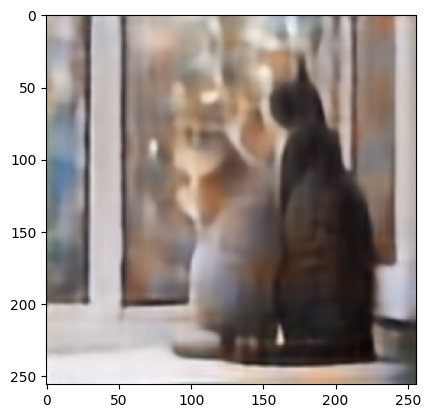

In [184]:
plt.imshow(cv2.cvtColor(np.swapaxes(test1.squeeze(0),0,2).numpy(),cv2.COLOR_BGR2RGB))

In [185]:
imagen_prueba.shape

(256, 256, 3)

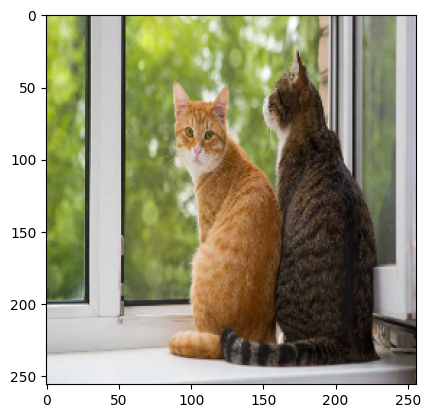

In [186]:
plt.imshow(cv2.cvtColor(imagen_prueba,cv2.COLOR_BGR2RGB))